# Evaluate the Harmony question matcher using the existing McElroy et al harmonisation tool as a gold standard

This is a validation of Harmony against the questionnaire harmonisation tool developed by McElroy et al in 2020.

You can read in detail about the validation report here:

https://harmonydata.org/measuring-the-performance-of-nlp-algorithms/

You can read an explanation of the technologies evaluated here:

https://harmonydata.org/how-does-harmony-work/

In [1]:
MODEL_NAME = "Model 6: Transformer with dot product similarity and preprocessing for opposite senses\ndistiluse-base-multilingual-cased-v2"

import sys
sys.path.append("../front_end")
from utils.question_matcher_transformer_huggingface_negation_efficient import QuestionMatcherTransformerHuggingFaceNegationEfficient
qm = QuestionMatcherTransformerHuggingFaceNegationEfficient('sentence-transformers/distiluse-base-multilingual-cased-v2')
match_function = lambda question_dfs : qm.match_questions(question_dfs)

/media/thomas/642d0db5-2c98-4156-b591-1a3572c5868c/anaconda3/envs/harmony/lib/python3.10/site-packages/torch/cuda/__init__.py:83: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at  ../c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


In [2]:
from load_validation_data import validation_data
from validation import validate

<Figure size 800x800 with 0 Axes>

Validating on dataset McElroy et al Childhood
	Processing 47 instruments of average length 23 questions each


/media/thomas/642d0db5-2c98-4156-b591-1a3572c5868c/anaconda3/envs/harmony/lib/python3.10/site-packages/sentence_transformers/util.py:58: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:204.)
  a = torch.tensor(a)


	Calculated 562315 match scores
	Generated 40708 gold-standard values to compare them to
	Calculating ROC curve

FALSE NEGATIVES OR WEAKEST MATCHES McElroy et al Childhood



,Instrument 1,Instrument 2,Score from model,Ground truth
0,Tries to Stop Quarrels,"Is helpful if someone is hurt, upset or feeling ill",0.01,1
1,Tries to Stop Quarrels,"Shares readily with other children (treats, toys, pencils etc)",0.01,1
2,"Is upset by new situation, by things happening for the first time","A dare devil""",0.02,1
3,Tries to Stop Quarrels,"Often volunteers to help others (parents, teachers, other children)",0.03,1
4,She is off and running as soon as she wakes up in the morning,I was very restless,0.03,1
5,Stares into Space,I felt so tired I just sat around and did nothing,0.03,1
6,Child likes to sit and watch TV rather than play active games,"""A very hard worker",0.03,1
7,Tries to be Fair in Games,"Often volunteers to help others (parents, teachers, other children)",0.04,1
8,She is something of a loner,Gets on better with adults than with other children,0.04,1
9,"Is nervous or clingy in new situations, easily loses confidence","A dare devil""",0.04,1



FALSE POSITIVES OR WEAKEST REJECTIONS McElroy et al Childhood



,Instrument 1,Instrument 2,Score from model,Ground truth
0,"Overcompetitive with other children""","diffident about competing with other children""",0.90,0
1,Gets on With Other Children,Fights with other children,0.89,0
2,Gets on With Other Children,Interferes with the activity of other children,0.81,0
3,Other Children Dislike Child,Child bullies other children,0.80,0
4,Fights With Other Children,"Overcompetitive with other children""",0.80,0
5,Child bullies other children,Is bullied by other children,0.80,0
6,"usually gloomy and sad"" or ""Normal attitude to criticism and punishment","frequently disobedient"" or ""Normal attitude to criticism and punishment",0.80,0
7,Gets on With Other Children,"Overcompetitive with other children""",0.80,0
8,Other Children Dislike Child,Bullies other children,0.79,0
9,Gets on With Other Children,Child fights with other children,0.79,0


Validating on dataset McElroy et al Adulthood
	Processing 28 instruments of average length 16 questions each
	Calculated 95600 match scores
	Generated 9468 gold-standard values to compare them to
	Calculating ROC curve

FALSE NEGATIVES OR WEAKEST MATCHES McElroy et al Adulthood



,Instrument 1,Instrument 2,Score from model,Ground truth
0,I cried a lot,Been able to enjoy your normal daytoday activities (*note this is the closest approximation of 'low mood' identified in this measure This items may be better conceptualised as capturing 'loss of interest'),0.01,1
1,I did everything wrong,What is your opinion of yourself compared to other people (rate selfdepreciation),0.01,1
2,I did everything wrong,Are you selfconscious in public (rate simple ideas of reference),0.04,1
3,I laughed a lot,Been able to enjoy your normal daytoday activities (*note this is the closest approximation of 'low mood' identified in this measure This items may be better conceptualised as capturing 'loss of interest'),0.05,1
4,I felt miserable or unhappy,Been able to enjoy your normal daytoday activities (*note this is the closest approximation of 'low mood' identified in this measure This items may be better conceptualised as capturing 'loss of interest'),0.05,1
5,"Do you often feel on edge, or keyed up, or mentally tense or strained (rate nervous tension)",Found everything getting on top of you,0.06,1
6,I hated myself,Felt that you are playing a useful part in things,0.06,1
7,I hated myself,Are you selfconscious in public (rate simple ideas of reference),0.06,1
8,muscles feel tensed up (rate muscular tension),Found everything getting on top of you,0.07,1
9,I thought nobody really loved me,Been satisfied with the way you've carried out your task,0.07,1



FALSE POSITIVES OR WEAKEST REJECTIONS McElroy et al Adulthood



,Instrument 1,Instrument 2,Score from model,Ground truth
0,Do you suddenly become scared for no good reason,Been getting scared or panicky for no good reason,0.77,0
1,Do you often suddenly become scared for no good reason,Been getting scared or panicky for no good reason,0.76,0
2,Do you often feel depressed,Do you often feel tired most of the time,0.74,0
3,Are you frightened of going out alone or of meeting people,Are you scared to be alone when there are not friends near you,0.73,0
4,Have you been a very nervous person,Have you ever had a nervous breakdown,0.73,0
5,Felt that life is entirely hopeless,Felt that life isn't worth living,0.72,0
6,Do you often feel depressed,Do you feel tired most of the time,0.71,0
7,Do you often feel tired most of the time,Do you often feel miserable or depressed,0.71,0
8,Did you feel worn out,Felt that you are ill,0.70,0
9,Have you felt downhearted and low,Did you feel worn out,0.69,0


Validating on dataset GAD-7 (EN/PT)
Found Portuguese dataset GAD-7 (EN/PT)
Found Portuguese dataset GAD-7 (EN/PT)
	Processing 2 instruments of average length 7 questions each
	Calculated 49 match scores
	Generated 49 gold-standard values to compare them to
	Calculating ROC curve

FALSE NEGATIVES OR WEAKEST MATCHES GAD-7 (EN/PT)



,Instrument 1,Instrument 2,Score from model,Ground truth
0,Being so restless that it is hard to sit still,Ficar tão agitado/a que se torna difícil permanecer sentado/a,0.59,1
1,"Feeling nervous, anxious, or on edge","Sentir-se nervoso/a, ansioso/a ou muito tenso/a",0.64,1
2,Worrying too much about different things,Preocupar-se muito com diversas coisas,0.65,1
3,Becoming easily annoyed or irritable,Ficar facilmente aborrecido/a ou irritado/a,0.73,1
4,Not being able to stop or control worrying,Não ser capaz de impedir ou de controlar as preocupações,0.75,1
5,"Feeling afraid, as if something awful might happen",Sentir medo como se algo horrível fosse acontecer,0.76,1
6,Trouble relaxing,Dificuldade para relaxar,0.82,1



FALSE POSITIVES OR WEAKEST REJECTIONS GAD-7 (EN/PT)



,Instrument 1,Instrument 2,Score from model,Ground truth
0,Being so restless that it is hard to sit still,Dificuldade para relaxar,0.53,0
1,Becoming easily annoyed or irritable,Dificuldade para relaxar,0.48,0
2,"Feeling nervous, anxious, or on edge",Ficar facilmente aborrecido/a ou irritado/a,0.44,0
3,Becoming easily annoyed or irritable,"Sentir-se nervoso/a, ansioso/a ou muito tenso/a",0.42,0
4,Becoming easily annoyed or irritable,Ficar tão agitado/a que se torna difícil permanecer sentado/a,0.40,0
5,Becoming easily annoyed or irritable,Não ser capaz de impedir ou de controlar as preocupações,0.39,0
6,"Feeling afraid, as if something awful might happen","Sentir-se nervoso/a, ansioso/a ou muito tenso/a",0.39,0
7,Trouble relaxing,Ficar facilmente aborrecido/a ou irritado/a,0.38,0
8,Not being able to stop or control worrying,Ficar facilmente aborrecido/a ou irritado/a,0.36,0
9,"Feeling nervous, anxious, or on edge",Não ser capaz de impedir ou de controlar as preocupações,0.36,0


Validating on dataset BHRCS SDQ/CBCL (PT)
Found Portuguese dataset BHRCS SDQ/CBCL (PT)
Found Portuguese dataset BHRCS SDQ/CBCL (PT)
	Processing 2 instruments of average length 73 questions each
	Calculated 3025 match scores
	Generated 3025 gold-standard values to compare them to
	Calculating ROC curve

FALSE NEGATIVES OR WEAKEST MATCHES BHRCS SDQ/CBCL (PT)



,Instrument 1,Instrument 2,Score from model,Ground truth
0,É alvo de muitas gozações,Outras crianças pegam no pé ou a atormentam,0.03,1
1,É barulhento(a) demais,Pensa nas coisas antes de fazê-las,0.03,1
2,Grita muito,Frequentemente tem acessos de raiva ou crises de birra,0.05,1
3,Fica emburrado(a) facilmente,Frequentemente tem acessos de raiva ou crises de birra,0.06,1
4,Fala demais,Pensa nas coisas antes de fazê-las,0.06,1
5,Não vai bem na escola,"Completa as tarefas que começa, tem boa concentração",0.12,1
6,Não consegue tirar certos pensamentos da cabeça (obsessões),"Tem muitas preocupações, muitas vezes parece preocupado com tudo",0.12,1
7,É impulsivo(a) ou age sem pensar,Pensa nas coisas antes de fazê-las,0.12,1
8,É nervoso(a) ou tenso(a),"Tem muitas preocupações, muitas vezes parece preocupado com tudo",0.12,1
9,É muito acanhado(a) ou tímido(a),"Fica inseguro quando tem que fazer alguma coisa pela primeira vez, facilmente perde a confiança em si mesmo",0.12,1



FALSE POSITIVES OR WEAKEST REJECTIONS BHRCS SDQ/CBCL (PT)



,Instrument 1,Instrument 2,Score from model,Ground truth
0,"Desrespeita as regras em casa, na escola ou em outros lugares","Rouba coisas de casa, da escola ou de outros lugares",0.43,0
1,As outras crianças não gostam dele(a),Outras crianças pegam no pé ou a atormentam,0.39,0
2,Prefere estar com crianças mais novos,Se dá melhor com adultos do que com outros jovens,0.39,0
3,Não se dá bem com outras crianças,Outras crianças pegam no pé ou a atormentam,0.39,0
4,Tem medo de pensar ou fazer alguma coisa má,"Tem muitos medos, assusta-se facilmente",0.38,0
5,"É cruel, intimida ou faz maldade com outros","Tenta ser atencioso se alguém parece magoado, aflito ou se sentindo mal",0.36,0
6,Prefere estar com crianças mais novos,É gentil com crianças mais novas,0.35,0
7,Reclama de solidão,"É solitário, prefere brincar sozinho",0.35,0
8,Não se dá bem com outras crianças,É gentil com crianças mais novas,0.35,0
9,As outras crianças não gostam dele(a),É gentil com crianças mais novas,0.34,0


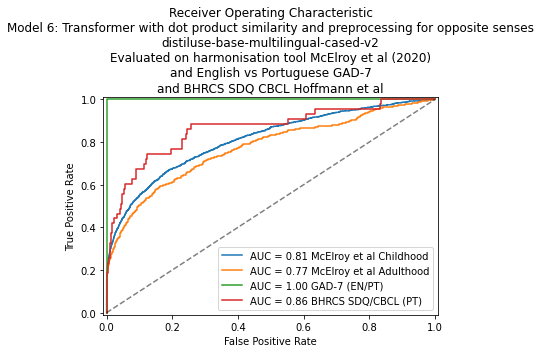

In [3]:
validate(validation_data, match_function, MODEL_NAME)